In [41]:
import datetime
from twython import Twython
import csv
import numpy as np
import json
from matplotlib import pyplot as plt
import textblob
import botometer

In [60]:
# returns list of lists from csv file file
def fromCSV(file='movie_ratings.csv'):
    with open(file, newline='') as csvfile:
        names = list(csv.reader(csvfile))
    return names

# writes a list of lists data to file
def toCSV(file, data):
    with open(file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [61]:
def toJSON(lines, file='movie_tweets.json'):
    def default(obj):
        if type(obj).__module__ == np.__name__:
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return obj.item()
        raise TypeError('Unknown type:', type(obj))
    
    with open(file, 'w') as fp:
        json.dump(lines, fp, default=default)
        
def fromJSON(file):
    with open(file) as handle:
        dictdump = json.loads(handle.read())
        
    return dictdump

In [62]:
# gets authenticated Twython twiter object with apikey and apisecret
def getTwitter(apiKey, apiSecret):
    t = Twython(apiKey, apiSecret, oauth_version=2)
    t = Twython(apiKey, access_token=t.obtain_access_token())
    return t

In [63]:
# searches for tweets with query from fromDate to toDate with full (True) or 30 day endpoint (False)
# env should be name of twitter developer environment name
def getTweets(twitter, query, toDate=None, fromDate=None, maxResults=10, full=False, env="mov"):
    params = {"query":query + " lang:en", "maxResults":maxResults}
    
    if toDate:
        params["toDate"] = toDate.strftime('%Y%m%d%H%M')
    if fromDate:
        params["fromDate"] = fromDate.strftime('%Y%m%d%H%M')

    if full:
        return twitter.get('https://api.twitter.com/1.1/tweets/search/fullarchive/'+env+'.json', 
                           params=params)['results']
    else:
        return twitter.get('https://api.twitter.com/1.1/tweets/search/30day/'+env+'.json', 
                           params=params)['results']

In [64]:
# gets dictionary of movie names : tweets about movie from movie queries and names
def getMoviesTweets(t, queries, info):
    movie_tweets = {}
    
    for i, movie in enumerate(queries):
        tweets = t.search(q=movie, count=100, lang="en")["statuses"]
        movie_tweets[info[i+1][0]] = tweets
        
    return movie_tweets

In [65]:
# gets dictionary of movie tweets at least endDates old
def getOldMoviesTweets(t, queries, info, endDates):
    old_tweets = {}

    for i, query in enumerate(queries):
        date = datetime.datetime.strptime(endDates[i], "%Y-%m-%d")
        tweets = getTweets(t, query, toDate=date, maxResults=100, full=True, env="mov")
        old_tweets[data[i+1][0]] = tweets
    
    return old_tweets

In [66]:
# from list of tweets returns list of polarities on [-1, 1], negative to positive polarity
def getSentiment(tweets, analyzer=textblob.sentiments.NaiveBayesAnalyzer()):
    sent = []
    for tweet in tweets:
        sent.append(textblob.TextBlob(tweet["text"], analyzer=sAnalyzer).sentiment[2])

In [78]:
# from list of tweets returns non-bot tweets -- takes forever
def filterBotTweets(tweets):
    rapidapi_key = RAPID_KEY
    botometer_api_url = 'https://botometer-pro.p.rapidapi.com'
    twitter_app_auth = {
        'consumer_key': API_KEY,
        'consumer_secret': API_SECRET,
        'access_token': ACCESS_TOKEN,
        'access_token_secret': ACCESS_SECRET,
      }
    bom = botometer.Botometer(botometer_api_url=botometer_api_url, wait_on_ratelimit=True, 
                              rapidapi_key=rapidapi_key, **twitter_app_auth)

    accounts = []
    for tweet in tweets:
        accounts.append('@' + tweet["user"]["screen_name"])
        
    results = np.array(list(bom.check_accounts_in(accounts)))

    mask = []
    for _, res in results:
        if (len(res) > 2) and (res["cap"]["english"] > 0.5):
            mask.append(False)
        else:
            mask.append(True)
            
            
    return np.array(tweets)[mask]

In [ ]:
# gets a week's worth of tweets in a list starting at startDay (a datetime object) with query query
def getWeekTweets(twitter, query, startDay):
    weekTweets = []
    endDay = startDay.replace(hour=23, minute=59)

    for i in range(7):
        weekTweets.extend(getTweets(twitter, query, toDate=endDay, fromDate=startDay, maxResults=100))
        
        startDay += datetime.timedelta(days=1)
        endDay += datetime.timedelta(days=1)
        
        time.sleep(4)

    return weekTweets

In [86]:
# gets dictionary of movie tweets spanning a week starting at startDay
def getMoviesWeekTweets(t, queries, info, startDay):
    movie_tweets = {}
    
    for i, movie in enumerate(queries):
        tweets = getWeekTweets(t, movie, startDay)
        movie_tweets[info[i+1][0]] = tweets
        time.sleep(4)
        
    return movie_tweets

In [ ]:
for key in rKeys:
    fTweets[key] = filterBotTweets(tweets[key])
    print(datetime.datetime.now(), key)

2020-04-29 20:38:42.420921 Queen & Slim


(array([11.,  5., 30., 26., 11.,  7.,  1.,  4.,  3.,  2.]),
 array([0.01633043, 0.1105329 , 0.20473537, 0.29893784, 0.39314031,
        0.48734278, 0.58154525, 0.67574772, 0.76995018, 0.86415265,
        0.95835512]),
 <a list of 10 Patch objects>)

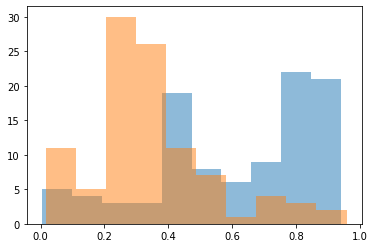

In [359]:
plt.hist(koS, alpha=0.5)
plt.hist(cakS, alpha=0.5)